In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
#!pip install pmdarima --quiet
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima


In [2]:
ari = pd.read_csv("data_ari.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])
ari = ari.drop(columns=['Unnamed: 0']).reset_index(drop=True)


In [3]:
#BE#
ari_BE = ari[ari['location']=="BE"]
train = ari_BE[ari_BE['truth_date']<="2023-09-01"]
test = ari_BE[ari_BE['truth_date']>"2023-09-01"]

In [4]:
test.head()

,location,truth_date,year_week,value,relative_humidity_2m,temperature_2m_max,temperature_2m_min,covid
4581,BE,2023-09-03,2023-W35,644.000000,81.516396,21.778788,12.793073,1
4590,BE,2023-09-10,2023-W36,801.299988,69.918970,29.343073,17.778786,1
4598,BE,2023-09-17,2023-W37,767.200012,77.600945,23.314500,14.457357,1
4608,BE,2023-09-24,2023-W38,979.299988,77.417410,19.407358,12.450215,1
4629,BE,2023-10-01,2023-W39,1233.599976,76.305850,22.207357,13.014501,1


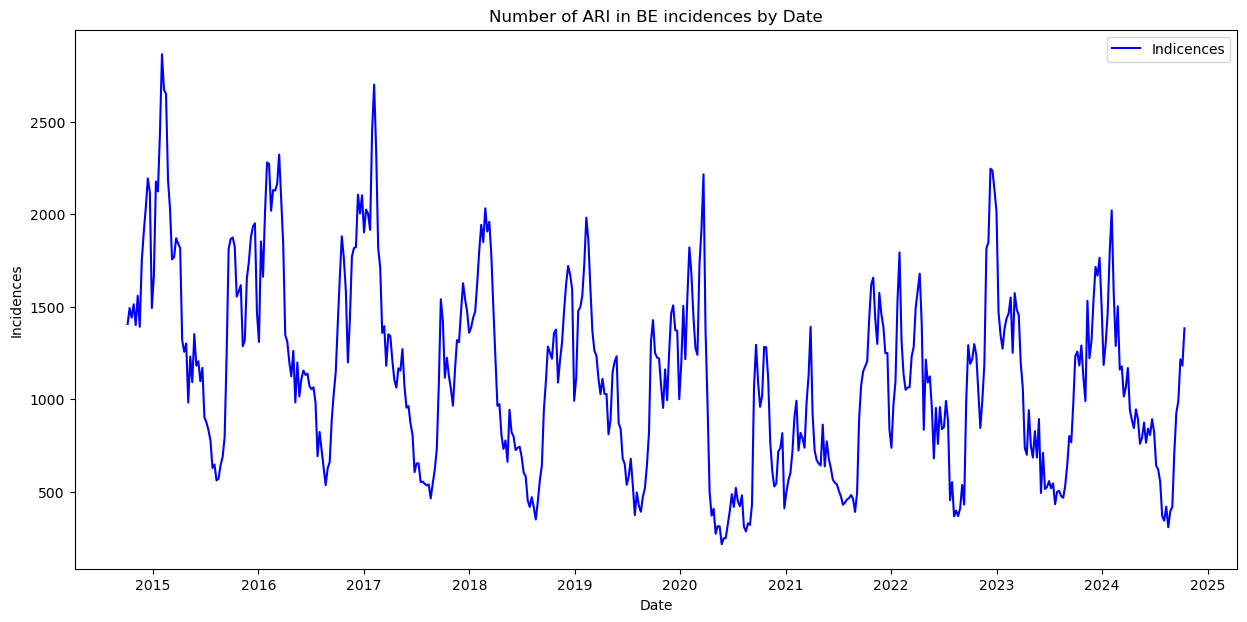

In [5]:
import matplotlib.dates as mdates
plt.figure(figsize=(15, 7))
plt.title("Number of ARI in BE incidences by Date")
plt.xlabel('Date')
plt.ylabel('Incidences')
plt.plot(ari_BE['truth_date'], ari_BE['value'], label='Indicences', color='blue')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Tick every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()  
plt.show()

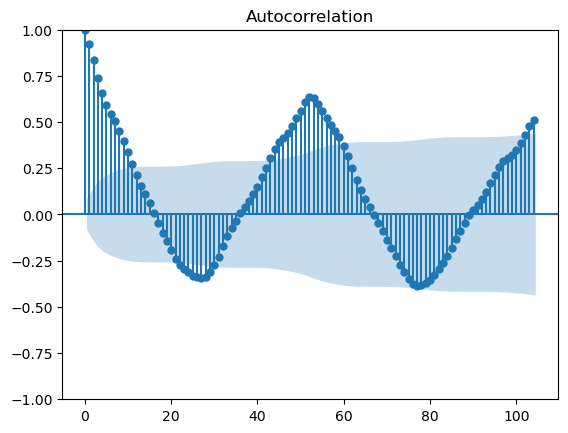

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ari_BE['value'], lags=104)  # Check 2 years (104 weeks)
plt.show()

C:\Users\flore\AppData\Local\Temp\ipykernel_12892\858665072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ari_BE["rolling_avg"] = ari_BE["value"].rolling(window=12).mean()  # 12 represents 12 periods (e.g., months)
C:\Users\flore\AppData\Local\Temp\ipykernel_12892\858665072.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ari_BE["rolling_std"] = ari_BE["value"].rolling(window=12).std()


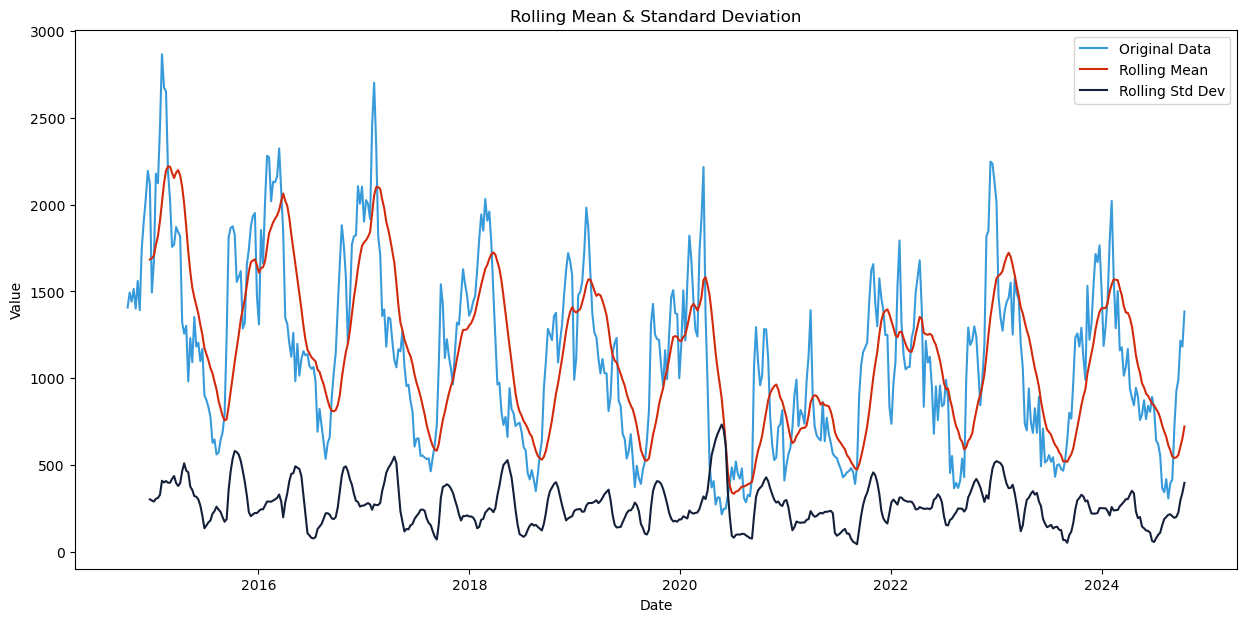

In [7]:
# Calculate rolling statistics
ari_BE["rolling_avg"] = ari_BE["value"].rolling(window=12).mean()  # 12 represents 12 periods (e.g., months)
ari_BE["rolling_std"] = ari_BE["value"].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.plot(ari_BE["truth_date"], ari_BE["value"], color='#379BDB', label='Original Data')  # Original data
plt.plot(ari_BE["truth_date"], ari_BE["rolling_avg"], color='#D22A0D', label='Rolling Mean')  # Rolling mean
plt.plot(ari_BE["truth_date"], ari_BE["rolling_std"], color='#142039', label='Rolling Std Dev')  # Rolling std dev
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [8]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(ari_BE['value'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -5.292725
p-value                          0.000006
#Lags Used                       2.000000
Number of Observations Used    521.000000
Critical Value (1%)             -3.442964
Critical Value (5%)             -2.867103
Critical Value (10%)            -2.569733
dtype: float64


The data is stationary, so we can apply. This means that we can apply models without diff

In [9]:
ARIMA_model = pm.auto_arima(train['value'], 
                      start_p=0, 
                      start_q=0,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

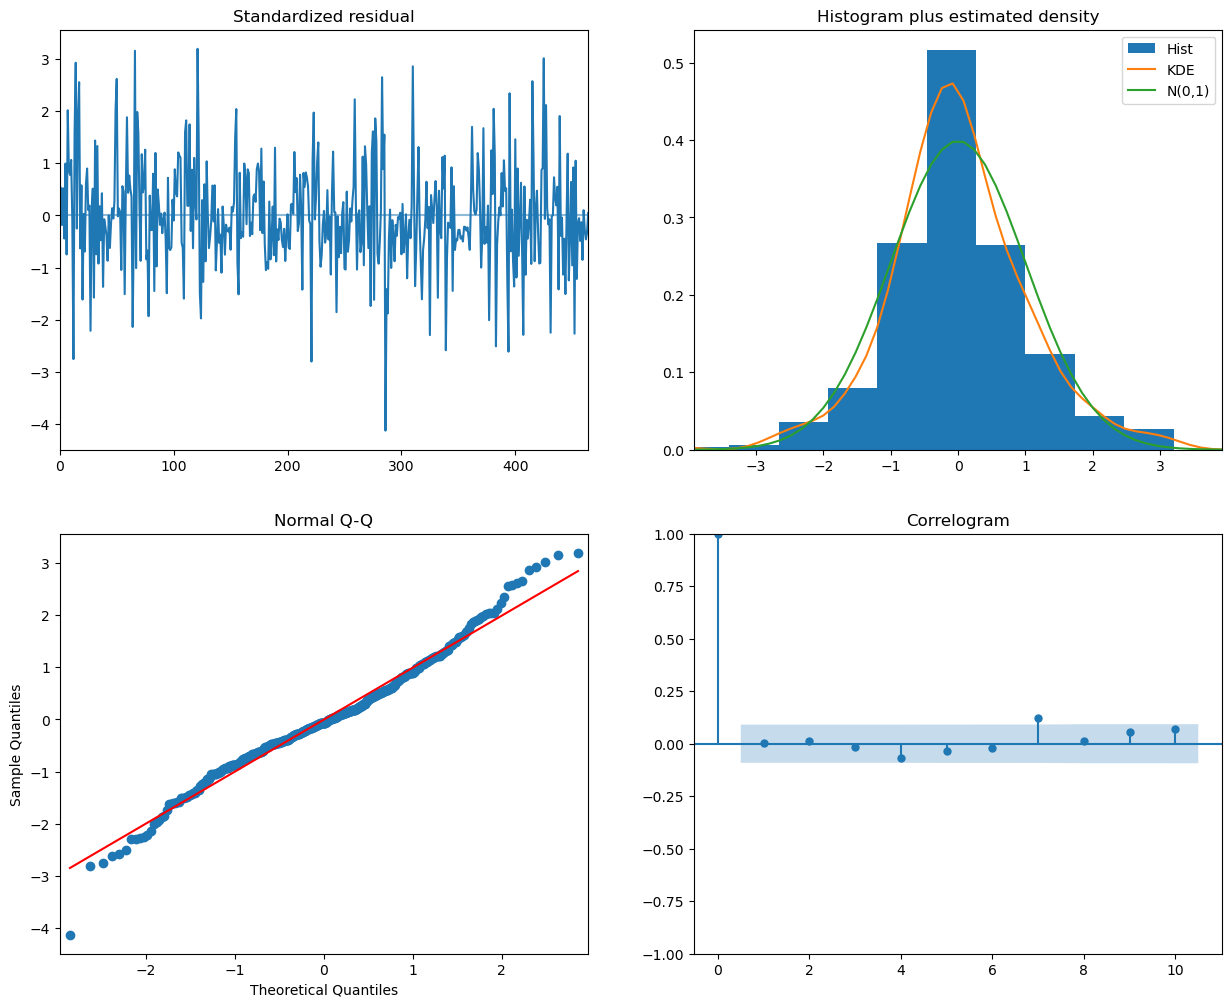

In [10]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [11]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(train["value"], start_p=1, start_q=1,
                        test='adf',
                        max_p=2, max_q=2, 
                        m=52, #52 is the frequncy of the cycle because is weekly
                        start_P=1, 
                        seasonal=True, #set to seasonal
                        d=None, 
                        D=1, #order of the seasonal differencing
                        trace=False,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

KeyboardInterrupt: 

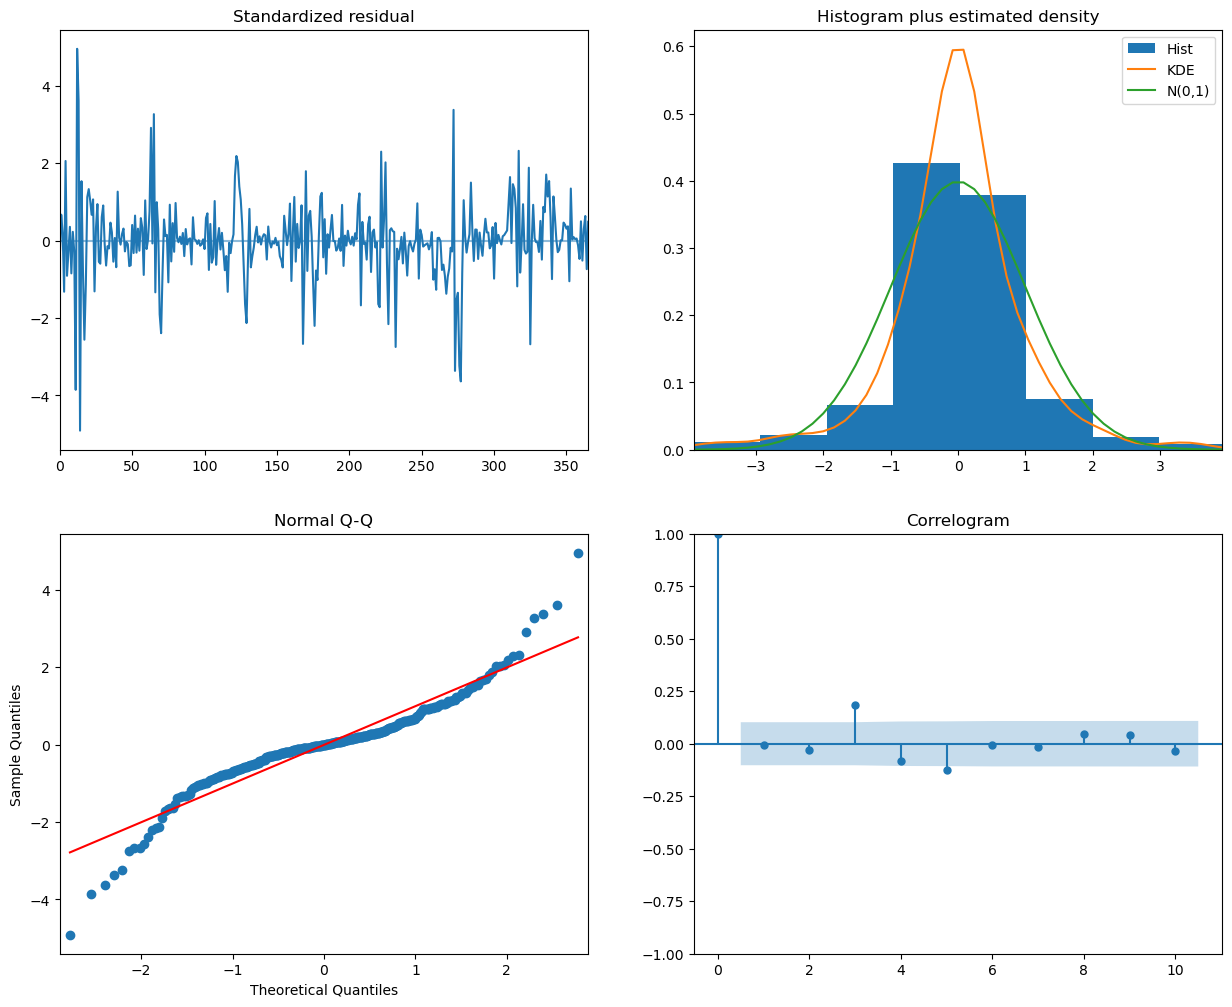

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
SARIMA_model.summary()

NameError: name 'SARIMA_model' is not defined

In [17]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Mean Absolute Percentage Error (MAPE): 16.20%


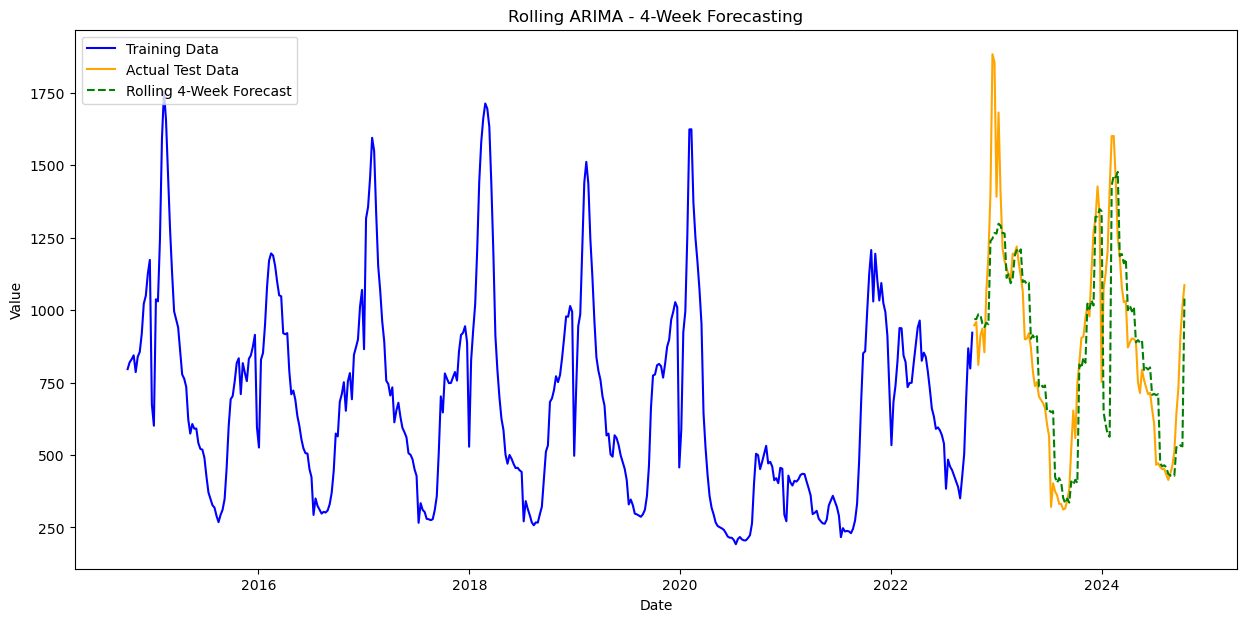

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
df = ari

# Convert 'truth_date' to datetime and sort data
df['truth_date'] = pd.to_datetime(df['truth_date'])
df = df.sort_values(by='truth_date')

# Select a single location (e.g., Czech Republic "CZ")
df_single = df[df["location"] == "CZ"].copy()

# Set 'truth_date' as index
df_single.set_index("truth_date", inplace=True)

# Train-test split (80% train, 20% test)
split_point = int(len(df_single) * 0.8)
train, test = df_single.iloc[:split_point], df_single.iloc[split_point:]

# Rolling 4-week forecast function
def rolling_forecast(ARIMA_order, train, test, step=4):
    history = list(train["value"])  # Start with training data
    predictions = []  
    test_index = test.index  # Store test index for plotting

    for i in range(0, len(test), step):
        # Fit ARIMA model on the available data
        model = ARIMA(history, order=ARIMA_order)
        model_fit = model.fit()
        
        # Forecast next 'step' periods (4 weeks)
        forecast = model_fit.forecast(steps=step)
        
        # Store predictions
        predictions.extend(forecast)
        
        # Move forward by 'step' weeks in real data
        actual_values = test["value"].iloc[i:i+step].tolist()
        history.extend(actual_values)  # Update history with real values

    # Convert predictions to Pandas Series
    predicted_series = pd.Series(predictions[:len(test)], index=test_index)  
    mape = mean_absolute_percentage_error(test["value"], predicted_series)
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    # Plot results
    plt.figure(figsize=(15, 7))
    plt.plot(train.index, train["value"], color='blue', label='Training Data')  
    plt.plot(test.index, test["value"], color='orange', label='Actual Test Data')  
    plt.plot(predicted_series, color='green', linestyle='dashed', label='Rolling 4-Week Forecast')  
    plt.legend(loc='upper left')
    plt.title("Rolling ARIMA - 4-Week Forecasting")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()
    return mape
# Run rolling forecast with 4-week step
mape_arima = rolling_forecast((2, 1, 2), train, test, step=4)


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_ind

Mean Absolute Percentage Error (MAPE): 16.78%


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


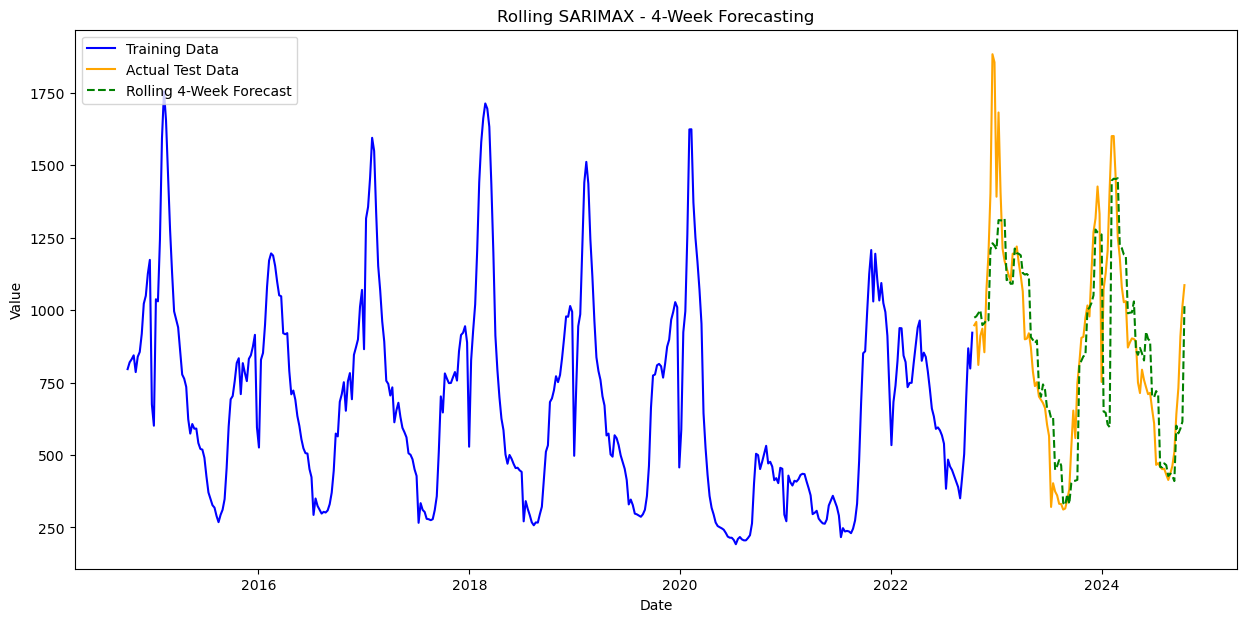

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Define exogenous variables
exog_vars = ['relative_humidity_2m', 'temperature_2m_max', 'temperature_2m_min', 'covid']

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Rolling 4-week forecast function with SARIMAX
def rolling_forecast_sarimax(order, train, test, exog_vars, step=4):
    history = list(train["value"])  # Start with training data
    exog_history = train[exog_vars].copy()  # Exogenous variables history
    predictions = []  
    test_index = test.index  # Store test index for plotting

    for i in range(0, len(test), step):
        # Ensure exog_train matches the length of history
        exog_train = exog_history.iloc[:len(history)]  

        # Fit SARIMAX model with exogenous variables
        model = SARIMAX(history, order=order, exog=exog_train)
        model_fit = model.fit(disp=False)

        # Forecast next 'step' periods using test exogenous data
        exog_forecast = test[exog_vars].iloc[i:i+step]  

        # **Fix: Ensure exog_forecast has the correct shape**
        if len(exog_forecast) < step:
            # Pad with the last available values if not enough rows
            last_row = exog_forecast.iloc[-1:]
            missing_rows = step - len(exog_forecast)
            exog_forecast = pd.concat([exog_forecast] + [last_row] * missing_rows)

        forecast = model_fit.forecast(steps=step, exog=exog_forecast)

        # Store predictions
        predictions.extend(forecast)

        # Move forward by 'step' weeks in real data
        actual_values = test["value"].iloc[i:i+step].tolist()
        history.extend(actual_values)  # Update history with real values
        exog_history = pd.concat([exog_history, test[exog_vars].iloc[i:i+step]])  # Update exogenous data

    # Convert predictions to Pandas Series
    predicted_series = pd.Series(predictions[:len(test)], index=test_index)  

    # Calculate MAPE
    mape = mean_absolute_percentage_error(test["value"], predicted_series)
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    # Plot results
    plt.figure(figsize=(15, 7))
    plt.plot(train.index, train["value"], color='blue', label='Training Data')  
    plt.plot(test.index, test["value"], color='orange', label='Actual Test Data')  
    plt.plot(predicted_series, color='green', linestyle='dashed', label='Rolling 4-Week Forecast')  
    plt.legend(loc='upper left')
    plt.title("Rolling SARIMAX - 4-Week Forecasting")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()
    return model, predicted_series, mape
# Run rolling forecast with SARIMAX
sarimax_mod,prediction_sarimax,mape_sarimax = rolling_forecast_sarimax((2, 1, 2), train, test, exog_vars, step=4)


In [23]:
mape_sarimax

np.float64(16.782649096279233)

In [25]:
import joblib

In [29]:
ARIMA_model = pm.auto_arima(train['value'],
                      exogenous = train[['relative_humidity_2m','temperature_2m_max','temperature_2m_min','covid']],
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=52,
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=True, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      n_jobs=-1,
                      stepwise=True)
model_path = "arima_model_be_v2.pkl"

# Save the model
joblib.dump(ARIMA_model, model_path)
print(f"Model saved at: {model_path}")

c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=16.24 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=6068.485, Time=0.01 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=4942.029, Time=6.74 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=5494.726, Time=8.76 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=6733.352, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=5093.048, Time=0.04 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=28.46 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=4919.271, Time=10.79 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=5000.519, Time=5.28 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=43.55 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=inf, Time=43.75 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,2)[52] intercept   : AIC=inf, Time=24.76 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=154.50 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=5810.455, Time=60.47 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=4903.671, Time=89.25 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=4963.496, Time=51.04 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=4912.242, Time=87.62 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=4904.722, Time=236.51 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,2)[52] intercept   : AIC=inf, Time=52.10 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=5060.826, Time=0.07 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,2)[52] intercept   : AIC=inf, Time=36.99 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=161.82 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=446.61 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[52] intercept   : AIC=4904.161, Time=96.60 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[52] intercept   : AIC=4915.660, Time=101.53 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=4905.123, Time=88.23 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=112.26 sec


c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[52]             : AIC=4914.324, Time=56.35 sec

Best model:  ARIMA(2,0,0)(1,0,1)[52] intercept
Total fit time: 2020.455 seconds
Model saved at: arima_model_be_v2.pkl


In [27]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  418
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 52)   Log Likelihood               -2445.836
Date:                              Fri, 28 Feb 2025   AIC                           4903.671
Time:                                      13:43:23   BIC                           4927.884
Sample:                                           0   HQIC                          4913.243
                                              - 418                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.7926      3.899      2.512      0.012       2.151      17.434
ar.L1          1.1454      0.034     34.071      0.000       1.080       1.211
ar.L2         -0.2196      0.034     -6.372      0.000      -0.287      -0.152
ar.S.L52       0.8113      0.036     22.586      0.000       0.741       0.882
ma.S.L52      -0.3851      0.061     -6.328      0.000      -0.504      -0.266
sigma2      6627.4676    275.262     24.077      0.000    6087.965    7166.970
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               376.97
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

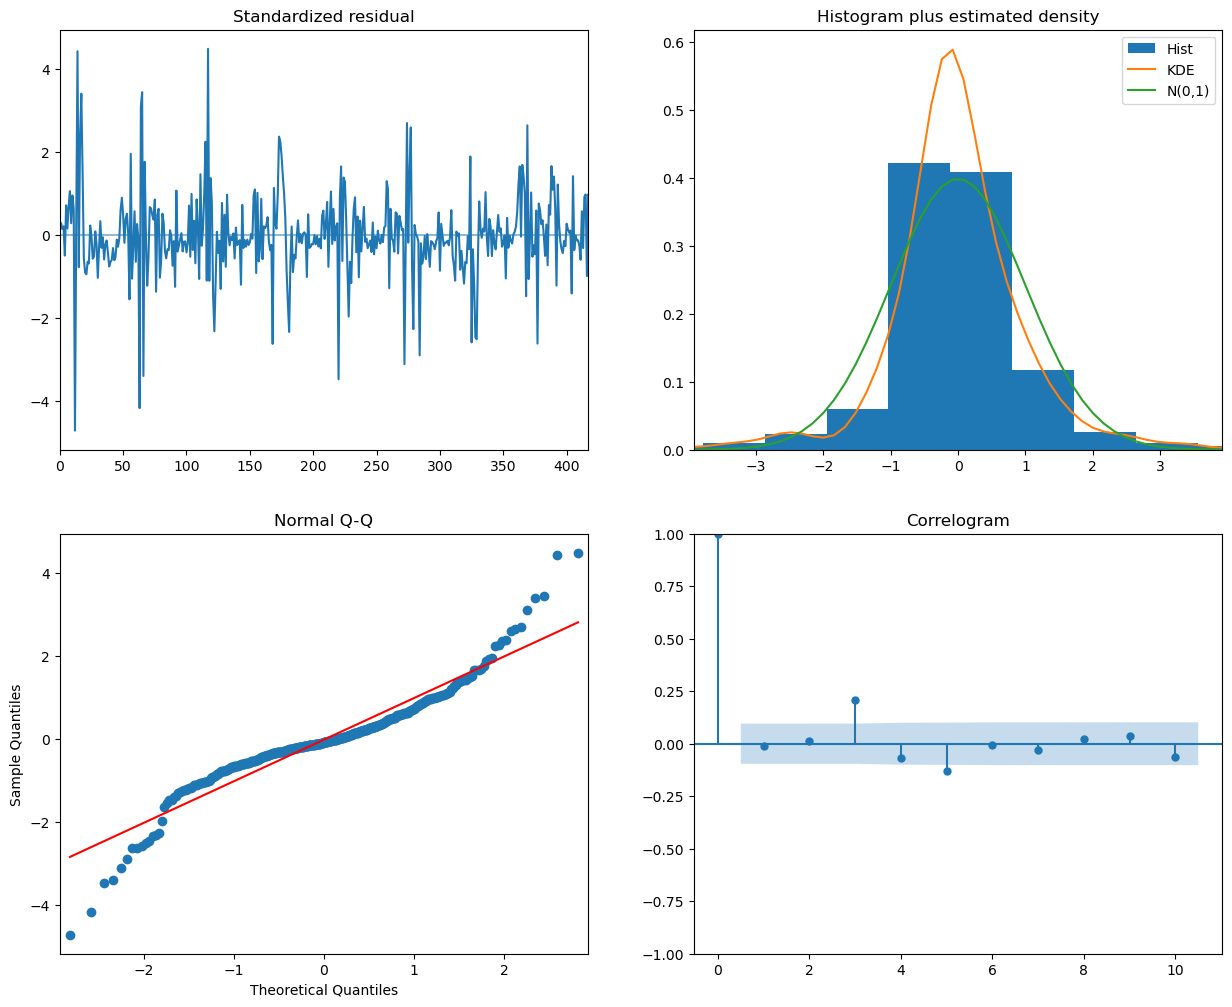

In [28]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()